In [1]:
"""
AE.pyをTensorflowベースで再実装
+主要関数をクラスモジュール化
"""

#%%
# cording = UTF-8
import os,re,random,copy
import scipy,librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn

#import keras

####################################初期化####################################
aug_amount = 100    #ファイルごとのAugmentationの回数
lr = 0.01           #初期学習率
alpha = 1e-05      #L2正則化の係数
dr_rate = 0.3       #ドロップアウト率
batch_size = 50
epochs = 100
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標
encode_dim = 500    #オートエンコーダの圧縮次元
n_components = 0.99 #疑似AEの保持分散

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")
log_dir = "./logs"       #Tensorboardログの保存パス
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
datafile = "dataset2.npz"

##################################クラス・関数##################################

#Augmentation関連関数のクラス
class Aug:
    def __init__(self,aug_amount,ok_dir,ng_dir,env_dir):
        self.aug_amount = aug_amount
        self.ok_dir = ok_dir
        self.ng_dir = ng_dir
        self.env_dir = env_dir

    #対象ディレクトリのファイル一覧を取得
    def get_file_list(self,dir):
        file_list = os.listdir(dir)
        print("get file_list :{}".format(file_list))
        return file_list
    
    #対象ディレクトリの最大ファイルをサーチ
    def wav_search(self,dir,f_list):
        #呼び出されるごとに初期化する
        wave_list = []
        file_size = 0
    
        return_path = os.path.abspath('./')
    
        os.chdir(dir)
        for i in f_list:
            search_index = re.search('.wav',i)
            if search_index:
                wave_list .append(i)
                if os.path.getsize(i) > file_size:
                    file_size = os.path.getsize(i)
                    largest_file = i
        
        os.chdir(return_path)   #カレントディレクトリを戻す
        print("get file :{0} ,file size:{1}"\
            .format(largest_file,file_size))
        return wave_list,largest_file,file_size
    
    #オーディオファイルの読み込み サンプルレート22.05kHz、モノラルで固定
    def load_wav(self,dir,file):
        #呼び出されるごとに初期化する
        wf = np.arange(0)

        f_path = os.path.join(dir,file)
        wf,sp_rate = librosa.load(f_path,sr=22050,mono = True)
        del sp_rate
        return wf
    
    #スペクトログラムの取得 パワースペクトラムのまま処理するならlibrosa不要
    def get_spg(self,wf):
        spg = np.arange(0)
        sp_f,sp_t,spg = scipy.signal.spectrogram(wf,fs=22050,
            window = np.hamming(1024),nfft =1024)
        spg = librosa.power_to_db(spg)
        spg =spg.astype('float16')
        return sp_f,sp_t,spg

    #Augmentationの処理
    def aug_process(self,frame,dir,wave_list,env_file):
        #呼び出されるごとに初期化する
        length = 0
        count = 0
        wf = np.arange(0)

        length = int(frame * 1.2)
        for i in wave_list:
            wf = self.load_wav(dir,i)
            for j in range(self.aug_amount):
                start = random.randint(0,len(env_file)-length)
                aug_wav = copy.deepcopy(env_file[start : start + length])
                del start
                start = random.randint(0,len(aug_wav) - len(wf))
                aug_wav = aug_wav + random.gauss(1,0.05)
                aug_wav[ start:start + len(wf) ] = \
                    aug_wav[ start : start + len(wf) ] + wf
                sp_f,sp_t,spg = self.get_spg(aug_wav)
                spg = spg.reshape(1,len(sp_f),len(sp_t))
                try:
                    X_data
                except:
                    X_data = copy.deepcopy(spg)
                else:
                    X_data = np.vstack((X_data,spg))
                del start,aug_wav,sp_f,sp_t,spg
                count = count + 1
            del wf
            print("Augmentation done! total count = {}".format(count))

        return X_data    

    #データセットの作成 ここまでの関数は全部ここに集約される
    #最大ファイルサイズに合わせてフレームサイズを定義し
    #OK・NG各データセットを作成後、結合する

    def new_dataset(self):
        #OKNGそれぞれのファイルリストと最大ファイルを取得
        ok_filelist = self.get_file_list(self.ok_dir)
        ok_wave_list,ok_largeest_name,ok_largest_size = self.wav_search(self.ok_dir,ok_filelist)
        ng_filelist = self.get_file_list(self.ng_dir)
        ng_wave_list,ng_largeest_name,ng_largest_size = self.wav_search(self.ng_dir,ng_filelist)

        #OKNGの最大を比較
        if ok_largest_size>ng_largest_size:
            largest_dir = self.ok_dir
            lergest_name = ok_largeest_name
            print("largetst:OK")
        else:
            largest_dir = self.ng_dir
            lergest_name = ng_largeest_name
            print("largetst:NG")

        #最大フレームサイズを取得
        wf = self.load_wav(largest_dir,lergest_name)
        frame = int(len(wf))
        #wf = np.insert(wf,frame,np.empty(int(frame*0.2))) #1.2倍する
        #sp_f,sp_t,spg = get_spg(wf) 
        #X_initsize = (len(sp_f),len(sp_t))
        #del wf,sp_f,sp_t,spg
        del wf

        #環境音データをロード
        env_data = self.load_wav(self.env_dir,"env.wav")
    
        #OKデータセット作成
        X_ok = copy.deepcopy(
            self.aug_process(frame,self.ok_dir,ok_wave_list,env_data)
            )
        y_ok = np.zeros(len(X_ok),dtype = 'bool')

        #NGデータセット作成
        X_ng = copy.deepcopy(
            self.aug_process(frame,self.ng_dir,ng_wave_list,env_data)
            )
        y_ng = np.ones(len(X_ng),dtype = 'bool')

        #データセットの結合
        X_data = np.vstack((X_ok,X_ng))
        y_data = np.append(y_ok,y_ng)
        del X_ok,y_ok,X_ng,y_ng

        return X_data,y_data

#データ前処理のクラス
class Pproc:
    def __init__(self):
        pass

    #TrainとTestを分離
    def t_t_sprit(self,X_data,y_data,test_size):
        from sklearn.model_selection import train_test_split
        X_train,X_test,y_train,y_test = \
        train_test_split(
            X_data.reshape(len(X_data),-1),
            y_data,
            test_size = test_size)
        return X_train,X_test,y_train,y_test

    #スケーラー
    def scaler(self):
        x = sklearn.preprocessing.MinMaxScaler()
        return x

    #AE学習用 Falseデータだけ抽出
    def m_sprit(self,X_mixed,y_mixed):
       #呼び出されるごとに初期化する
        try:
            X_sprit
        except:
            pass    #X_spritが存在しなければ何もしない
        else:
            del X_sprit #前のデータを消去する

        for i in range(len(X_mixed)):
            if y_mixed[i] == False:
                try:
                    X_sprit
                except: #X_spritを生成する
                    X_sprit = copy.deepcopy(X_mixed[i])
                    X_sprit = X_sprit.reshape(1,X_mixed.shape[1])
                else:   #既存のX_spritに追加する 前段の例外処理はここを避けるため
                    X_sprit = np.vstack(
                        (X_sprit,X_mixed[i].reshape(1,X_mixed.shape[1]))
                        )

        return X_sprit

#分類機の定義
class Estimator:
    def __init__(self):
        pass

    #オートエンコーダの定義
    def AE(self,input_dim,encode_dim,lr,alpha,dr_rate):
        from keras.models import Model,Sequential
        from keras.layers import Input, Dense,Dropout,Activation
        from keras.layers.normalization import BatchNormalization
        from keras import regularizers

        input_data = Input(shape = (input_dim,))

        #エンコーダを定義
        encoder = Dense(
            encode_dim,
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(alpha),
            )(input_data)
        encoder = BatchNormalization()(encoder)
        encoder = Dropout(dr_rate)(encoder)
        encoder = Activation("relu")(encoder)

        #デコーダを定義 こっちにはドロップアウトは定義しない
        decoder = Dense(input_dim,kernel_initializer="he_normal")(encoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation("sigmoid")(decoder)

        #モデルを定義
        x = Model(input = input_data,output = decoder)

        #最適化関数
        opt = keras.optimizers.Nadam(lr = lr)

        x.compile(
            optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
            )

        return x

    #PCAによる疑似エンコーダの定義 PCA_pyの取り込み       
    def Pseudo_AE(self,n_components):
        from sklearn.decomposition import PCA
        x = PCA(n_components=n_components)
        return x

#kerasのコールバックの定義
class K_cb:
    def __init__(self,monitor,log_dir,modeldir):
        self.monitor = monitor
        self.log_dir = log_dir
        self.modeldir = modeldir

    def cb_es(self): #早期打ち切り
        x = keras.callbacks.EarlyStopping(monitor = self.monitor,patience=5)
        return x

    def cb_tb(self): #TensorBordへの出力
        x = keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq=0, write_graph=True)
        return x

    def cb_rd(self): #自動学習率減衰(もともとNadamは減衰する decay=0.004)
        x = keras.callbacks.ReduceLROnPlateau(
            monitor = self.monitor,
            factor = 0.1,
            patience = 3,
            verbose = 1,
            min_lr = 1e-08
            )
        return x

    def cb_cp(self):    #モデルの保存
        x = keras.callbacks.ModelCheckpoint(
            filepath = self.modeldir,
            monitor = self.monitor,
            save_best_only=True
        )
        '''
        以下備忘
        https://qiita.com/yukiB/items/f45f0f71bc9739830002 より

        >modelの保存，読み込みはmodel.to_json()/model.to_yaml()，
        >model_from_json()/model_from_yaml()を使用します．

        '
        from keras.models import Sequential, model_from_json

        json_string = model.to_json()
        model = model_from_json(json_string)
        '

        >学習したParameterの保存＆読み込みは，
        >save_weights/load_weightsを使用します(h5pyが必要)．

        '
        model.save_weights('param.hdf5')
        model.load_weights('param.hdf5')
        '
        '''
        return x


In [2]:
###################################メイン処理###################################

#Augmentationインスタンスを生成しデータセット読み込み なければ作る
aug = Aug(
    aug_amount = aug_amount,
    ok_dir = ok_dir,
    ng_dir = ng_dir,
    env_dir = env_dir
    )

if os.path.exists(os.path.join(data_dir,datafile)) == False:
    X_data,y_data = aug.new_dataset()
    np.savez_compressed(os.path.join(data_dir,datafile),
        X = X_data,y = y_data)
    print("Data set saved!") #ファイルネーム表示機能つけること
else:
    load_data = np.load(os.path.join(data_dir,datafile))
    X_data =load_data['X']
    y_data = load_data['y']
    del load_data
    print("Data loaded!!")

X_shape = X_data.shape[1:]  #データの形状を取得


Data loaded!!


In [3]:
#前処理
pproc = Pproc()
#訓練データと学習データを分離
X_train,X_test,y_train,y_test = pproc.t_t_sprit(
    X_data,y_data,
    test_size=0.05
    )
del X_data,y_data
print("train/test sprited!!")

#Falseデータだけを分離
X_train_ae = pproc.m_sprit(X_train,y_train)
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)


train/test sprited!!
X_train for Autoencoder was splited!!
amount/shape:(1896, 60021)


In [4]:
#スケーラーの定義と前変換
scaler = pproc.scaler()
X_train_ae = scaler.fit_transform(X_train_ae)   #スケール変換
print("Scaler ready!!")


Scaler ready!!


Using TensorFlow backend.
Train on 1801 samples, validate on 95 samples
Epoch 1/100
1801/1801 [==============================] - 56s 31ms/step - loss: 0.7334 - accuracy: 0.0226 - val_loss: 1.9151 - val_accuracy: 0.0142
Epoch 2/100
1801/1801 [==============================] - 61s 34ms/step - loss: 0.6798 - accuracy: 0.0301 - val_loss: 1.4807 - val_accuracy: 0.0174
Epoch 3/100
1801/1801 [==============================] - 53s 30ms/step - loss: 0.6637 - accuracy: 0.0333 - val_loss: 0.9051 - val_accuracy: 0.0288
Epoch 4/100
1801/1801 [==============================] - 55s 31ms/step - loss: 0.6585 - accuracy: 0.0336 - val_loss: 0.7359 - val_accuracy: 0.0293
Epoch 5/100
1801/1801 [==============================] - 56s 31ms/step - loss: 0.6561 - accuracy: 0.0336 - val_loss: 0.8202 - val_accuracy: 0.0259
Epoch 6/100
1801/1801 [==============================] - 55s 31ms/step - loss: 0.6553 - accuracy: 0.0336 - val_loss: 0.8490 - val_accuracy: 0.0283
Epoch 7/100
1801/1801 [=======================

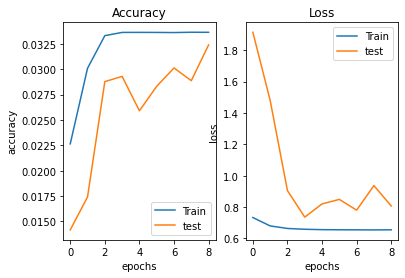

In [5]:
#エンコーダの準備
estimator = Estimator()
encoder = estimator.AE(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate
)
callback = K_cb(monitor = monitor,log_dir = log_dir,modeldir = modeldir)
#条件分岐を入れて、初期からの学習か転移学習かを選択させる(今後実装)

#疑似AEを使う場合は下記
#estimator = Estimator()
#encoder = estimator.Pseudo_AE(
#    n_components=n_components
#)

#学習させる
history = encoder.fit(
    X_train_ae,X_train_ae,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [callback.cb_es()], #,callback.cb_rd(),callback.cb?tb() うまく動かない
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')
encoder.summary() #疑似AE使用時はコメントアウト要

#学習曲線の表示
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Loss")

plt.show()


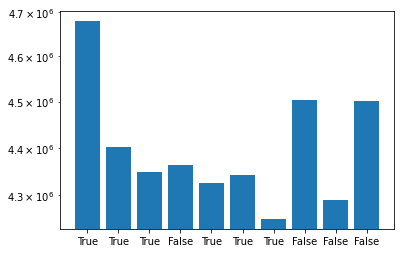

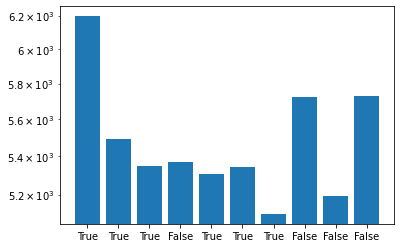

In [6]:
#推論を行う
X_decode = encoder.predict(scaler.transform(X_test))

#誤差スコアの計算 どちらがいいのかわからないので総和とMSE双方を計算
#総和の差分を計算
diff_score =np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_score[i] = np.sum(np.abs(X_test[i]-X_decode[i]))
plt.bar(range(10),diff_score[:10],tick_label = y_test[:10],log = True )
plt.show()

#MSEを計算
diff_mse = np.zeros(y_test.shape)
from sklearn.metrics import mean_squared_error
for i in range(X_test.shape[0]):
    diff_mse[i] = mean_squared_error(X_test[i],X_decode[i])
plt.bar(range(10),diff_mse[:10],tick_label = y_test[:10],log = True )
plt.show()

#以下追記要



学習のための必要機能の実装完了。
各機能をクラス化しながらメイン処理部の設計変更を行っていく